### 1. Imports and Setups

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque, defaultdict
import collections
import pickle
from tqdm import tqdm

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import time

# for plotting graphs
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/MyDrive/iisc/

/content/gdrive/MyDrive/iisc


In [4]:
from keras import backend as K
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
jobs = 8 
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
# Import the environment
from Env import CabDriver

#### 1. Defining Time Matrix

In [6]:
# Loading the time matrix 
Time_matrix = np.load("TM.npy")

In [7]:
Time_matrix.shape

(5, 5, 24, 7)

In [8]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


**Observation**
- The time matrix is 4 dimensional - start_location, end_location, hour of day, day of the week
-  The max time taken between 2 consequtive points is 11 hours, time can increase by a day

## 2.  Defining the MDP Environment

In [9]:
env = CabDriver()
action_space, state_space, state = env.reset()

**Observation**
- The state spaces are correctly initialized into a Vector [State, Day, Hour]

In [10]:
print ("The randomly initialized state is {}".format(state))

The randomly initialized state is [3, 16, 1]


In [11]:
env.requests(state)

([6, 3, 9, 4, 5, 19, 13, 18, 16, 0],
 [(1, 2),
  (0, 3),
  (2, 0),
  (0, 4),
  (1, 0),
  (4, 2),
  (3, 0),
  (4, 1),
  (3, 4),
  (0, 0)])

**Observation** 
- Returns the correct randomised action, and corresponding index, based on the traffic (Poisson Random Variable) for the location

In [12]:
Time_matrix[4,3,17,5]

6.0

In [13]:
env.next_state_func(state,[4,3],Time_matrix)

([3, 0, 2], 0, 6.0, 2.0)

In [14]:
state = [0,1,2]
env.state_encod_arch1(state)

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

**Observation** 
- The universal state space and action space look properly initialized
- The current state is randomly initialized
- The request function returns random states based on Traffic
- The next state is being generated, and encoded correctly

#### 2.1. Utilties

In [15]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


##### Epsilon- Greedy strategy

Way of selecting random actions with uniform distribution.
We can either select random action with epsilon probability or
We can select an action with 1-epsilon probably which will give maximum reward in a given state

Check epsilon decay over episodes

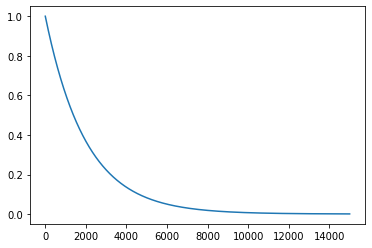

In [16]:
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = -0.0005
time_tic = np.arange(0,15000)
epsilon = []

#Number of episodes for training
for i in time_tic:
     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*i))

plt.plot(time_tic, epsilon)
plt.show()


##### Initialize Tracking States

In [17]:
def initialize_tracking_states():
    state_action_pair = [((0, 0, 0), (0, 1)),
                         ((0, 1, 1), (3, 4)),
                         ((1, 2, 2), (0, 2)),
                         ((1, 2, 2), (2, 3)),
                         ((2, 3, 3), (2, 1)),
                         ((2, 3, 3), (3, 4)),
                         ((3, 4, 4), (3, 0)), 
                         ((4, 4, 4), (1, 0)),
                         ((4, 5, 5), (0, 1)),
                         ((4, 5, 5), (1, 2))]

    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = defaultdict()
        tracked_states[state][action] = list()




##### Persist q-values corresponding for tracked states

In [18]:
def update_tracking_states(driver):
    for state in tracked_states.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
        q_predict = driver.model.predict(encoded_state)
        

        for action in tracked_states[state].keys():            
            action_index = list(
                filter(
                    lambda x: action == env.action_space[x],
                    range(0, len(env.action_space))))[0]
            q_value = q_predict[0][action_index]            
            tracked_states[state][action].append(q_value)

## 3. Defining the Agent Class




## Hyper parameters

*  state_size : vector length of encoded states (number of neurons in input layer) 
*   action_size : vector length of predicted q_values for all actions 
*  learning_rate
*  discount_factor
*  batch_size : batch size used in neural network for training
*  memory_length : replay memory buffer size



In [19]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Specifying hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k 
        self.epsilon_min = 0.001 
     
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
       
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

  
        self.model = self.build_model()


    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Input layer : 'state_size'       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Hidden Layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Output Layer : 'action_size'
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model

  
    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that the driver got.
        """        
         
        if np.random.rand() <= self.epsilon:
           
            return random.choice(possible_actions_index)            
        else:
        
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            q_value = self.model.predict(state)
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
     
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))

    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
           
            # initialize input state vector S
            state_input = np.zeros((self.batch_size, self.state_size))
            # initialize input state vector S'
            next_state_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate state_input, next_state_input and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                state_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                next_state_input[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            state_q_values = self.model.predict(state_input)
      
            next_state_q_values = self.model.predict(next_state_input)


       
            for i in range(self.batch_size):
                if done[i]:
                    state_q_values[i][actions[i]] = rewards[i]
                else:
                    state_q_values[i][actions[i]] = rewards[i] + self.discount_factor * np.max(next_state_q_values[i])
          
            self.model.fit(state_input, state_q_values, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        q_value = self.model.predict(self.track_state)
        
        
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
       
        q_value = self.model.predict(self.track_state)
        
      
        self.states_test.append(q_value[0][2])

    def save(self, name):        
        save_obj(self.model.get_weights(),  name)
    

## Initialization

In [20]:
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(0, 0, 0): defaultdict(None, {(0, 1): []}),
             (0, 1, 1): defaultdict(None, {(3, 4): []}),
             (1, 2, 2): defaultdict(None, {(0, 2): [], (2, 3): []}),
             (2, 3, 3): defaultdict(None, {(2, 1): [], (3, 4): []}),
             (3, 4, 4): defaultdict(None, {(3, 0): []}),
             (4, 4, 4): defaultdict(None, {(1, 0): []}),
             (4, 5, 5): defaultdict(None, {(0, 1): [], (1, 2): []})})

## 4. Training - DQN block

In [21]:


episode_time = 24*30 
total_episodes = 1000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

state_size = m+t+d
action_size = len(action_space)

rewards_per_episode, episodes = [], []

In [22]:
# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


## 5. Training Iteration

In [23]:
start_time = time.time()
score_tracked = []


for episode in tqdm(range(total_episodes)):

    terminal_state = False
    score = 0
    track_reward = False

    #reset at the start of each episode
    env = CabDriver()
    action_space, state_space, current_state = env.reset()
    

    total_time = 0
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(current_state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        current_action_idx = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(current_state, env.action_space[current_action_idx], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
          # if ride does not complete in stipulated time skip
          # it and move to next episode.
          terminal_state = True
        else:
          # 5. Append the experience to the memory
          agent.append_sample(current_state, current_action_idx, reward, next_state, terminal_state)
          # 6. Train the model by calling function agent.train_model
          agent.train_model()
          # 7. Keep a track of rewards, Q-values, loss
          score += reward
          current_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
      

    # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("\nEpisode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}\n".format(episode + 1,
                                                score,len(agent.memory),agent.epsilon, total_time))
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 50 == 0):       
        update_tracking_states(agent)

    # Total rewards per episode
    score_tracked.append(score)

           
elapsed_time = time.time() - start_time
print("\nElapsed Time :", elapsed_time, "\n")

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
 10%|█         | 100/1000 [01:28<13:19,  1.13it/s]


Episode 100, reward -351.0, memory_length 2000, epsilon 0.9517534529783257 total_time 727.0



 20%|██        | 200/1000 [02:53<11:20,  1.18it/s]


Episode 200, reward 93.0, memory_length 2000, epsilon 0.9053846599186395 total_time 727.0



 30%|███       | 300/1000 [04:20<09:49,  1.19it/s]


Episode 300, reward -225.0, memory_length 2000, epsilon 0.8612772995816813 total_time 725.0



 40%|████      | 400/1000 [05:44<08:34,  1.17it/s]


Episode 400, reward -252.0, memory_length 2000, epsilon 0.8193210805921111 total_time 725.0



 50%|█████     | 500/1000 [07:07<06:43,  1.24it/s]


Episode 500, reward -117.0, memory_length 2000, epsilon 0.7794110905484362 total_time 723.0



 60%|██████    | 600/1000 [08:29<05:24,  1.23it/s]


Episode 600, reward -279.0, memory_length 2000, epsilon 0.7414475336873622 total_time 730.0



 70%|███████   | 700/1000 [09:52<04:03,  1.23it/s]


Episode 700, reward -264.0, memory_length 2000, epsilon 0.7053354813424025 total_time 722.0



 80%|████████  | 800/1000 [11:16<02:46,  1.20it/s]


Episode 800, reward -12.0, memory_length 2000, epsilon 0.6709846345727669 total_time 726.0



 90%|█████████ | 900/1000 [12:36<01:20,  1.24it/s]


Episode 900, reward -160.0, memory_length 2000, epsilon 0.6383090983689743 total_time 727.0



100%|██████████| 1000/1000 [13:59<00:00,  1.19it/s]


Episode 1000, reward -287.0, memory_length 2000, epsilon 0.6072271668705884 total_time 728.0


Elapsed Time : 839.8525819778442 



In [24]:
agent.save(name="model_weights")

## 6. Tracking Convergence

In [25]:
 tracked_states_plotting=[]
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))
            # selecting only the states with non-zero values for plotting
            if (number_of_tracked_q_values):              
              tracked_states_plotting.append((st,ac))

state - (0, 0, 0) - action - (0, 1) - 20
state - (0, 1, 1) - action - (3, 4) - 20
state - (1, 2, 2) - action - (0, 2) - 0
state - (1, 2, 2) - action - (2, 3) - 20
state - (2, 3, 3) - action - (2, 1) - 14
state - (2, 3, 3) - action - (3, 4) - 20
state - (3, 4, 4) - action - (3, 0) - 20
state - (4, 4, 4) - action - (1, 0) - 18
state - (4, 5, 5) - action - (0, 1) - 20
state - (4, 5, 5) - action - (1, 2) - 20


**Observation** 
- There are values in the saved states which can be plotted


**draw convergence plot for a state - action pair**

In [26]:
def plot_q_val_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [27]:
def plot_q_val_log_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")



**Display convergence of tracked states**

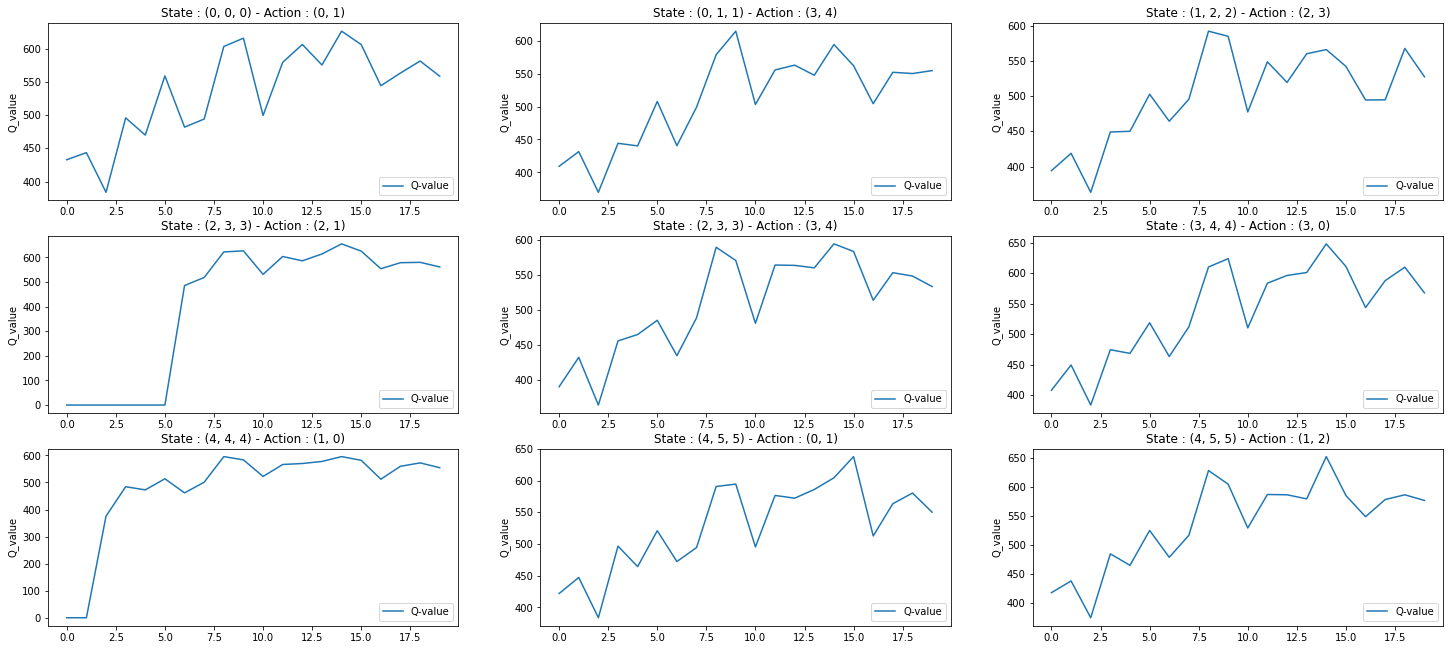

In [28]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_convergence(state, action)
    i +=1

**Observation** 
- The Q Value is steadily showing improvement spikes as the number of runs are increasing, which shows that the model is learning

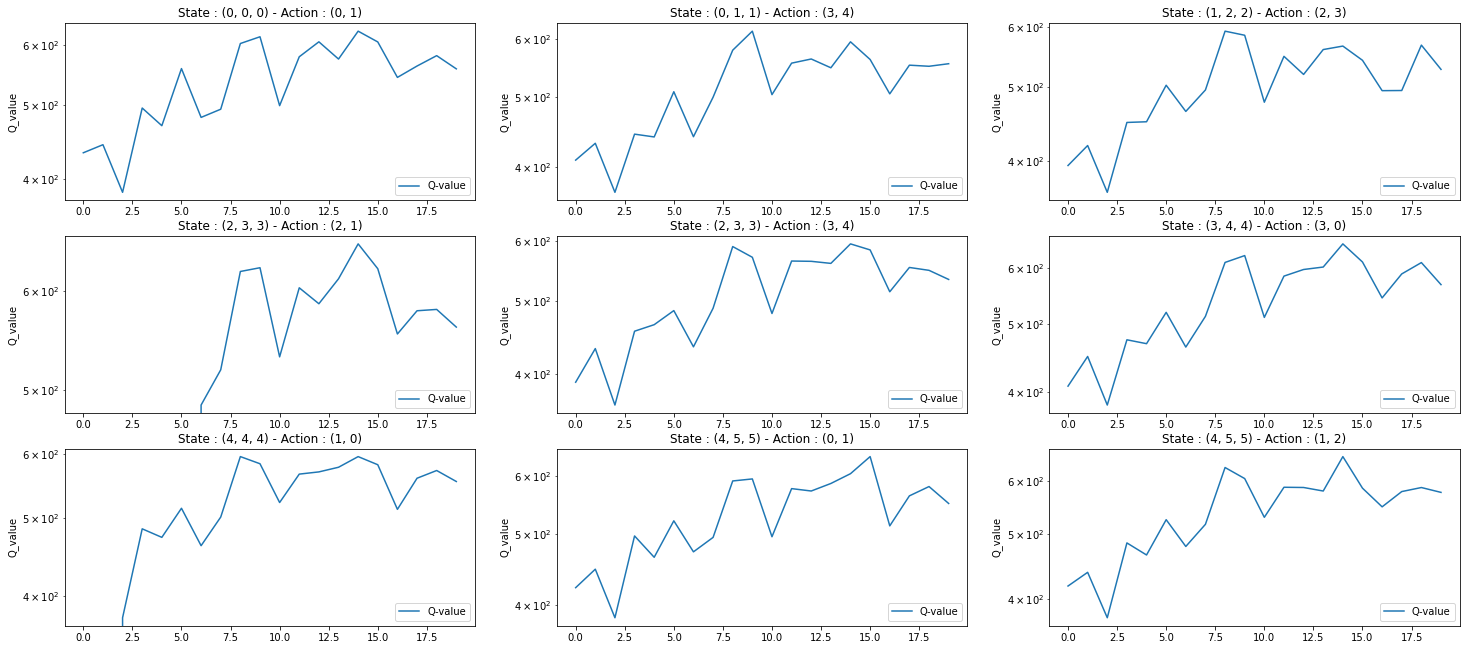

In [29]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_log_convergence(state, action)
    i +=1

**Observation**  
- We can repeat the experiment with close to 1K runs and check for improvement of Q Values

**Plotting Average Monthly Rewards**

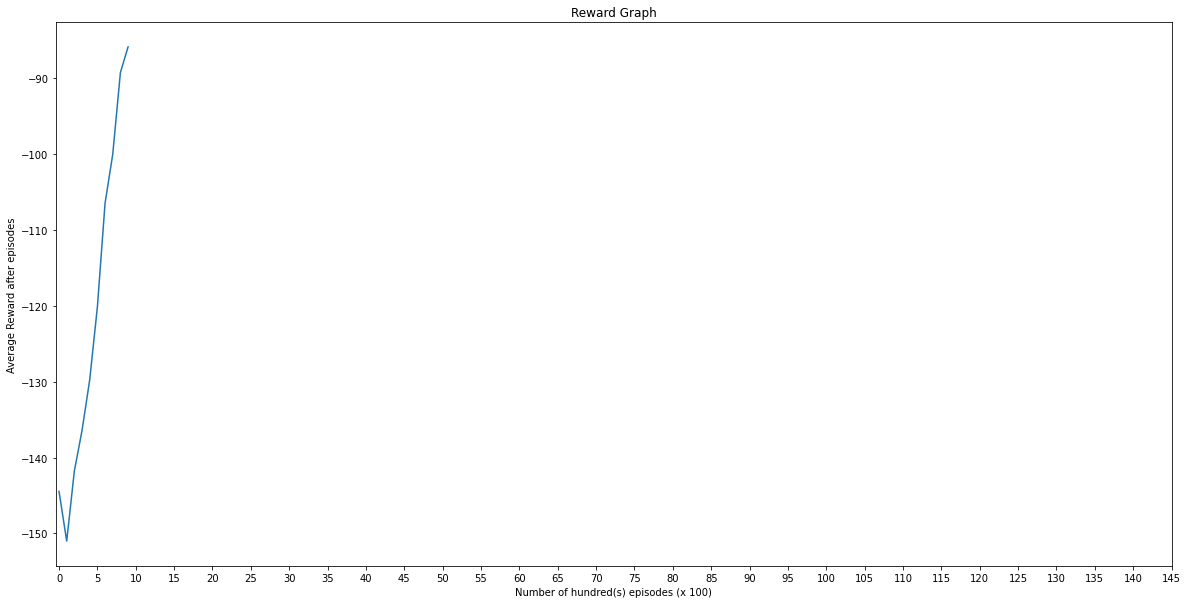

In [31]:
avg_monthly_rewards = [
    np.mean(rewards_per_episode[0:x + 99])
    for x in range(0, total_episodes, 100)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hundred(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()

**Conclusion**
- We have been able to create a Deep Q Model, which learns the Env and able to predict Actions, which can maximise the reward, which is the goal of this assignment.
- As seen above, we start with a low Reward, and slowly the graph rises up to better rewards
- Having said that, we need to run many more iterations, to get to better results, which we havent done due to infrastructure and time constraints.